<a id="top"></a> 
## Fetch - Data Analyst Take Home
Allison Liu 01/29/2025

<a id="0"></a> <br>
### Table of Content
#### 1. [Data Cleaning & Data Aggregation](#1)
- [User Table](#2)
- [Transactions Table](#3)
- [Products Table](#4)
#### 2. [Three Key Questions](#5)
- 2.1 [Explore the Data](#6)  
Are there any data quality issues present?  
Are there any fields that are challenging to understand?
- 2.2 [Provide SQL Queries](#7)  
What are the top 5 brands by receipts scanned among users 21 and over?  
What are the top 5 brands by sales among users that have had their account for at least six months?  
Who are Fetch’s power users?
- 2.3 [Communicate with Stakeholders](#8)

<a id="1"></a> 
## 1. Data Cleaning & Data Aggregation
Understand 3 key tables and perform data preprocessing.  
**Workflow**:   
1. Verify column types and identify non-numeric values
2. Detect outliers
3. Handle missing values
4. Column aggregation
5. Remove duplicate rows and drop unnecessary columns

 [*Back to top*](#top)

In [1]:
# Import necessary libraries and packages
import pandas as pd
from pandasql import sqldf
import sqlite3
from datetime import date
from tabulate import tabulate

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [2]:
# Read 3 tables
User = pd.DataFrame(pd.read_csv("USER_TAKEHOME.csv"))
Transactions = pd.DataFrame(pd.read_csv("TRANSACTION_TAKEHOME.csv"))
Products = pd.DataFrame(pd.read_csv("PRODUCTS_TAKEHOME.csv"))

<a id="2"></a> 
### User Table
**Workflow**:
1. Verify column types and convert to correct column types
4. Categorize `GENDER` column
5. Calculate age and accounts holding time
7. Handle missing values
8. Visualize the users by age, state, and accounts duration groups

 [*Back to top*](#top)

1. Verify column types and convert to correct column types  
Understand column types and extract date from `CREATED_DATE` and `BIRTH_DATE`

In [3]:
# Display user table
User

,ID,CREATED_DATE,BIRTH_DATE,STATE,LANGUAGE,GENDER
0,5ef3b4f17053ab141787697d,2020-06-24 20:17:54.000 Z,2000-08-11 00:00:00.000 Z,CA,es-419,female
1,5ff220d383fcfc12622b96bc,2021-01-03 19:53:55.000 Z,2001-09-24 04:00:00.000 Z,PA,en,female
2,6477950aa55bb77a0e27ee10,2023-05-31 18:42:18.000 Z,1994-10-28 00:00:00.000 Z,FL,es-419,female
3,658a306e99b40f103b63ccf8,2023-12-26 01:46:22.000 Z,NaN,NC,en,NaN
4,653cf5d6a225ea102b7ecdc2,2023-10-28 11:51:50.000 Z,1972-03-19 00:00:00.000 Z,PA,en,female
...,...,...,...,...,...,...
99995,61fc06d41febf771966da8fa,2022-02-03 16:46:12.000 Z,1992-03-16 08:00:00.000 Z,CA,en,female
99996,6391e7ef90ad5449ec5f782d,2022-12-08 13:34:39.000 Z,1993-09-23 05:00:00.000 Z,MO,en,female
99997,637d5efdd6f2a49c49934dcb,2022-11-22 23:45:05.000 Z,1983-04-19 00:00:00.000 Z,RI,en,female
99998,5f0de23b05d8a6147dc0cafa,2020-07-14 16:50:04.000 Z,1995-06-09 04:00:00.000 Z,DE,en,female


In [4]:
# Convert the string columns of CREATED_DATE and BIRTH_DATE to date type using 'to_date'
User["CREATED_DATE"] = pd.to_datetime(User["CREATED_DATE"]).dt.tz_localize(None)
User["BIRTH_DATE"] = pd.to_datetime(User["BIRTH_DATE"]).dt.tz_localize(None)

User["CREATED_DATE"] = User["CREATED_DATE"].dt.date
User["BIRTH_DATE"] = User["BIRTH_DATE"].dt.date
User.dtypes

ID              object
CREATED_DATE    object
BIRTH_DATE      object
STATE           object
LANGUAGE        object
GENDER          object
dtype: object

In [5]:
# Check the unique values in the LANGUAGE column
User.groupby('LANGUAGE')['ID'].count()

# After verifying the language code 'es-419', I found that it represents Spanish (Latin America).

LANGUAGE
en        63403
es-419     6089
Name: ID, dtype: int64

2. Categorize `GENDER` groups  
Replace self-reported answers with predefined categories.

In [6]:
# Check gender categories
User.groupby('GENDER')['ID'].count()

GENDER
My gender isn't listed        5
Non-Binary                   34
Prefer not to say             1
female                    64240
male                      25829
non_binary                  473
not_listed                  180
not_specified                28
prefer_not_to_say          1350
transgender                1772
unknown                     196
Name: ID, dtype: int64

In [7]:
# Replace gender into categories
User['GENDER'] = User['GENDER'].replace({"My gender isn't listed": 'not_listed', 
                                         'Prefer not to say':'prefer_not_to_say'})
User

,ID,CREATED_DATE,BIRTH_DATE,STATE,LANGUAGE,GENDER
0,5ef3b4f17053ab141787697d,2020-06-24,2000-08-11,CA,es-419,female
1,5ff220d383fcfc12622b96bc,2021-01-03,2001-09-24,PA,en,female
2,6477950aa55bb77a0e27ee10,2023-05-31,1994-10-28,FL,es-419,female
3,658a306e99b40f103b63ccf8,2023-12-26,NaT,NC,en,NaN
4,653cf5d6a225ea102b7ecdc2,2023-10-28,1972-03-19,PA,en,female
...,...,...,...,...,...,...
99995,61fc06d41febf771966da8fa,2022-02-03,1992-03-16,CA,en,female
99996,6391e7ef90ad5449ec5f782d,2022-12-08,1993-09-23,MO,en,female
99997,637d5efdd6f2a49c49934dcb,2022-11-22,1983-04-19,RI,en,female
99998,5f0de23b05d8a6147dc0cafa,2020-07-14,1995-06-09,DE,en,female


In [8]:
# Check gender categories
User.groupby('GENDER')['ID'].count()

GENDER
Non-Binary              34
female               64240
male                 25829
non_binary             473
not_listed             185
not_specified           28
prefer_not_to_say     1351
transgender           1772
unknown                196
Name: ID, dtype: int64

3. Calculate `AGE` and `ACCOUNT_MONTHS`  
Use **today**'s date to calculate the user's age and the duration of account ownership in months

In [9]:
# Calculate age from today
today = pd.Timestamp(date.today())
User['AGE'] = ((today - pd.to_datetime(User['BIRTH_DATE'])).dt.days / 365).round(1)

User

,ID,CREATED_DATE,BIRTH_DATE,STATE,LANGUAGE,GENDER,AGE
0,5ef3b4f17053ab141787697d,2020-06-24,2000-08-11,CA,es-419,female,24.5
1,5ff220d383fcfc12622b96bc,2021-01-03,2001-09-24,PA,en,female,23.4
2,6477950aa55bb77a0e27ee10,2023-05-31,1994-10-28,FL,es-419,female,30.3
3,658a306e99b40f103b63ccf8,2023-12-26,NaT,NC,en,NaN,NaN
4,653cf5d6a225ea102b7ecdc2,2023-10-28,1972-03-19,PA,en,female,52.9
...,...,...,...,...,...,...,...
99995,61fc06d41febf771966da8fa,2022-02-03,1992-03-16,CA,en,female,32.9
99996,6391e7ef90ad5449ec5f782d,2022-12-08,1993-09-23,MO,en,female,31.4
99997,637d5efdd6f2a49c49934dcb,2022-11-22,1983-04-19,RI,en,female,41.8
99998,5f0de23b05d8a6147dc0cafa,2020-07-14,1995-06-09,DE,en,female,29.7


Based on Fetch's Terms of Service, which state that the services are not directed at children **under 13 years old** and that Fetch does not knowingly collect or maintain personal information from children under 13, I believe it is reasonable to exclude this age group from further analysis.

In [10]:
# Remove users under age of 13
User = User[~(User['AGE'] < 13)]
User.shape

(99953, 7)

In [11]:
# Calculate accounts holding months
User['ACCOUNT_MONTHS'] = ((today - pd.to_datetime(User['CREATED_DATE'])).dt.days / 30).round(1)
User

,ID,CREATED_DATE,BIRTH_DATE,STATE,LANGUAGE,GENDER,AGE,ACCOUNT_MONTHS
0,5ef3b4f17053ab141787697d,2020-06-24,2000-08-11,CA,es-419,female,24.5,56.0
1,5ff220d383fcfc12622b96bc,2021-01-03,2001-09-24,PA,en,female,23.4,49.6
2,6477950aa55bb77a0e27ee10,2023-05-31,1994-10-28,FL,es-419,female,30.3,20.3
3,658a306e99b40f103b63ccf8,2023-12-26,NaT,NC,en,NaN,NaN,13.3
4,653cf5d6a225ea102b7ecdc2,2023-10-28,1972-03-19,PA,en,female,52.9,15.3
...,...,...,...,...,...,...,...,...
99995,61fc06d41febf771966da8fa,2022-02-03,1992-03-16,CA,en,female,32.9,36.4
99996,6391e7ef90ad5449ec5f782d,2022-12-08,1993-09-23,MO,en,female,31.4,26.1
99997,637d5efdd6f2a49c49934dcb,2022-11-22,1983-04-19,RI,en,female,41.8,26.6
99998,5f0de23b05d8a6147dc0cafa,2020-07-14,1995-06-09,DE,en,female,29.7,55.3


I checked the Fetch App release year and found that actual users should not have created accounts before **2017**. Therefore, I assumed that these were only testing accounts before the app launched, so I removed them.

In [12]:
# Remove created year before 2017
User = User[pd.to_datetime(User["CREATED_DATE"]) >= pd.to_datetime('2017-01-01')]
User.shape

(99802, 8)

In [13]:
# Drop duplicates
User = User.drop_duplicates()
User.shape

(99802, 8)

In [14]:
# Describe user table
User.describe()

,AGE,ACCOUNT_MONTHS
count,96127.000000,99802.000000
mean,40.436895,37.157383
std,15.156163,18.609448
min,13.000000,4.700000
25%,27.000000,24.300000
50%,39.300000,35.300000
75%,50.900000,50.600000
max,124.300000,98.200000


4. Handle missing values  
By writing a function to generate a summary table for missing values

In [15]:
# Write a function to show the missing values table
def missing_values_summary(df):
    missing_summary = pd.DataFrame({
        'Column': df.columns,
        'Non-Null Count': df.notnull().sum(),
        '% of Missing Values': (df.isnull().sum() / len(df)) * 100
    }).reset_index(drop=True)
    
    return missing_summary

# Call the function on User DataFrame
missing_values_summary(User)

,Column,Non-Null Count,% of Missing Values
0,ID,99802,0.000000
1,CREATED_DATE,99802,0.000000
2,BIRTH_DATE,96127,3.682291
3,STATE,95105,4.706319
4,LANGUAGE,69459,30.403198
5,GENDER,93964,5.849582
6,AGE,96127,3.682291
7,ACCOUNT_MONTHS,99802,0.000000


It’s challenging to decide whether to remove missing values or keep them, as each user row is meaningful. Therefore, I would like to request guidance on the appropriate actions.

5. Visualize User Table
- Top 20 States
- Age group distribution
- Account holding year distribution

- Top 20 Number of Users by States

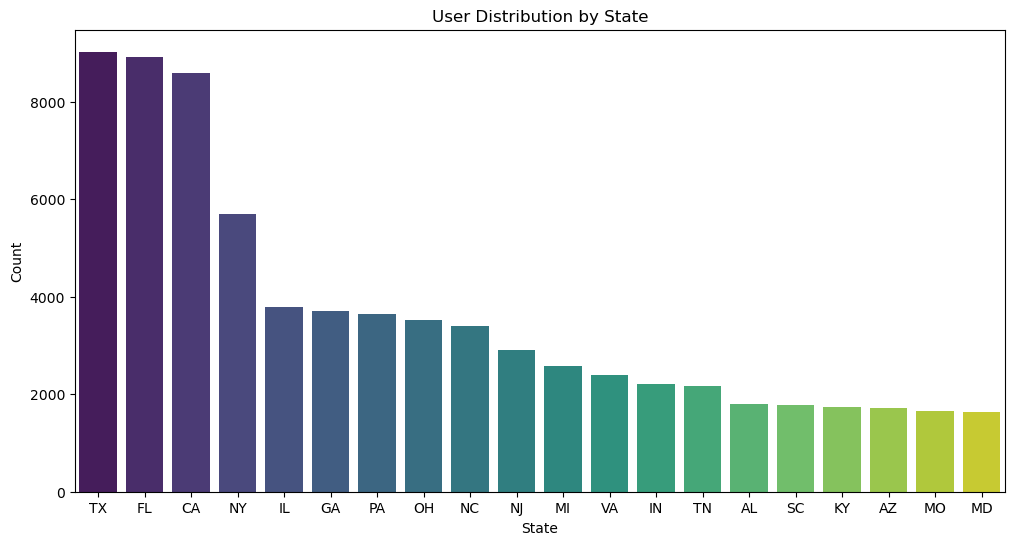

In [16]:
# Group by state, count occurrences, and sort
state_counts = (
    User.groupby("STATE")["ID"]
    .count()
    .reset_index()
    .rename(columns={"ID": "STATE_CNT"})
    .sort_values("STATE_CNT", ascending=False)
    .head(20)
)

# Set figure size
plt.figure(figsize=(12, 6))

# Create Seaborn bar plot
sns.barplot(data=state_counts, x="STATE", y="STATE_CNT", palette="viridis")

# Add title and labels
plt.title('User Distribution by State')
plt.xlabel('State')
plt.ylabel('Count')
plt.show()

- Number of Users by Age Group

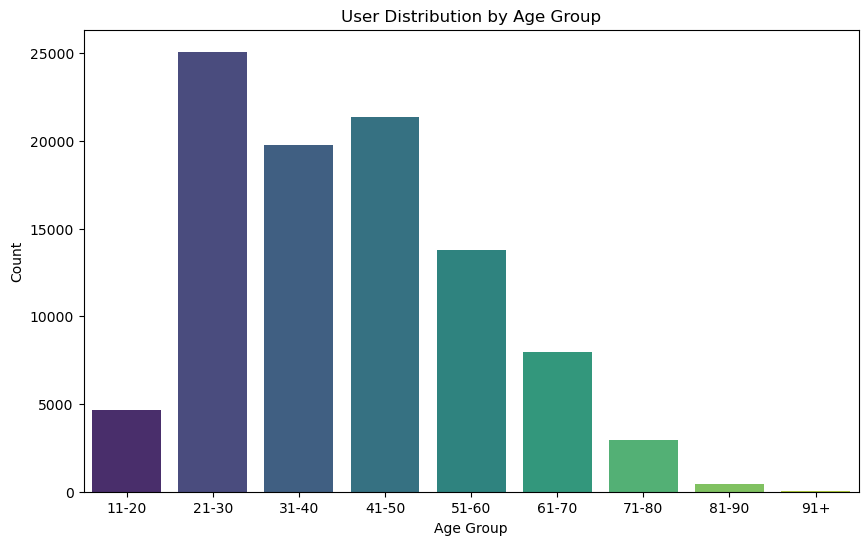

In [17]:
# Define AGE_GROUP based on conditions
bins = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels = ["11-20", "21-30", "31-40", "41-50", "51-60", "61-70", "71-80", "81-90", "91+"]
User["AGE_GROUP"] = pd.cut(User["AGE"], bins=bins, labels=labels, right=True)

# Group by AGE_GROUP and count occurrences
age_counts = (
    User.groupby("AGE_GROUP")["ID"]
    .count()
    .reset_index()
    .rename(columns={"ID": "COUNT"})
)

# Set figure size
plt.figure(figsize=(10, 6))

# Create Seaborn bar plot
sns.barplot(data=age_counts, x="AGE_GROUP", y="COUNT", palette="viridis")

# Add title and labels
plt.title('User Distribution by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.show()

- Number of Users by Accounts Holding Years

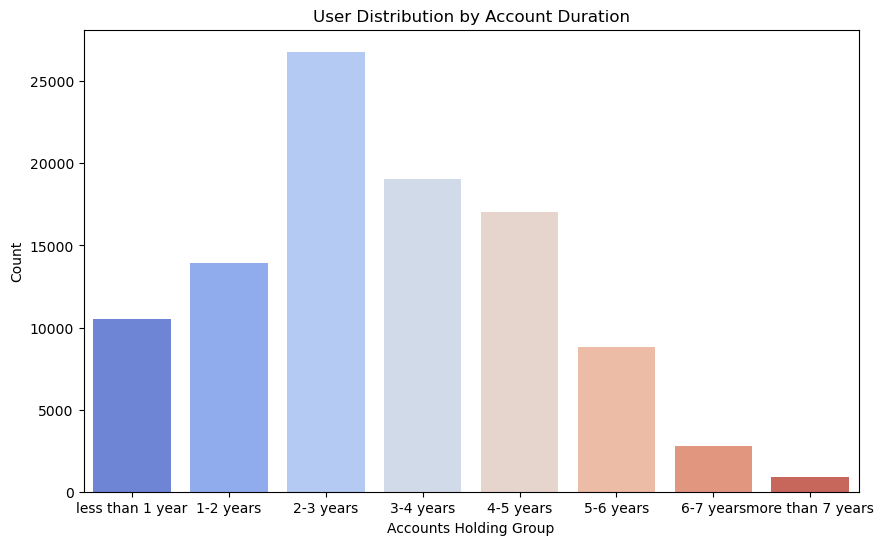

In [18]:
# Define bins and labels for account tenure
bins = [0, 12, 24, 36, 48, 60, 72, 84, float("inf")]
labels = [
    "less than 1 year", 
    "1-2 years", 
    "2-3 years", 
    "3-4 years", 
    "4-5 years", 
    "5-6 years", 
    "6-7 years", 
    "more than 7 years"
]

# Categorize the users based on account months
User["ACCOUNT_MONTHS_GROUP"] = pd.cut(User["ACCOUNT_MONTHS"], bins=bins, labels=labels, right=True)

# Group by account tenure category and count occurrences
account_counts = (
    User.groupby("ACCOUNT_MONTHS_GROUP")["ID"]
    .count()
    .reset_index()
    .rename(columns={"ID": "COUNT"})
)

# Set figure size
plt.figure(figsize=(10, 6))

# Create Seaborn bar plot
sns.barplot(data=account_counts, x="ACCOUNT_MONTHS_GROUP", y="COUNT", palette="coolwarm")

# Add title and labels
plt.title('User Distribution by Account Duration')
plt.xlabel('Accounts Holding Group')
plt.ylabel('Count')
plt.show()

Based on the graphs above, we can see that most of our users are from TX, FL, and CA, and are between 21-50 years old. Additionally, most users created their accounts 2-5 years ago.

<a id="3"></a> 
### Transactions Table
1. Verify column types, convert to correct types, and identify non-numeric values
2. Identify and handle outliers in `FINAL_QUANTITY`
3. Aggregate data by `RECEIPT_ID`, `USER_ID`, and `BARCODE`
4. Filter out `FINAL_SALE` = 0 and `PURCHASE_DATE` later than `SCAN_DATE`
5. Visualize transaction trends by `FINAL_QUANTITY` and `FINAL_SALE`

 [*Back to top*](#top)

1. Verify column types, convert non-numeric `FINAL_QUANTITY` into numeric, and understand the Transactions table

In [19]:
# Display whole data order by receipt id
Transactions.sort_values(by='RECEIPT_ID')

,RECEIPT_ID,PURCHASE_DATE,SCAN_DATE,STORE_NAME,USER_ID,BARCODE,FINAL_QUANTITY,FINAL_SALE
0,0000d256-4041-4a3e-adc4-5623fb6e0c99,2024-08-21,2024-08-21 14:19:06.539 Z,WALMART,63b73a7f3d310dceeabd4758,1.530001e+10,1.00,
41567,0000d256-4041-4a3e-adc4-5623fb6e0c99,2024-08-21,2024-08-21 14:19:06.539 Z,WALMART,63b73a7f3d310dceeabd4758,1.530001e+10,1.00,1.54
1,0001455d-7a92-4a7b-a1d2-c747af1c8fd3,2024-07-20,2024-07-20 09:50:24.206 Z,ALDI,62c08877baa38d1a1f6c211a,NaN,zero,1.49
39291,0001455d-7a92-4a7b-a1d2-c747af1c8fd3,2024-07-20,2024-07-20 09:50:24.206 Z,ALDI,62c08877baa38d1a1f6c211a,NaN,1.00,1.49
2,00017e0a-7851-42fb-bfab-0baa96e23586,2024-08-18,2024-08-19 15:38:56.813 Z,WALMART,60842f207ac8b7729e472020,7.874223e+10,1.00,
...,...,...,...,...,...,...,...,...
28152,fffbb112-3cc5-47c2-b014-08db2f87e0c7,2024-07-30,2024-08-04 11:43:31.474 Z,WALMART,5eb59d6be7012d13941af5e2,8.180000e+11,1.00,4.88
24998,fffbfb2a-7c1f-41c9-a5da-628fa7fcc746,2024-07-28,2024-07-28 11:47:34.180 Z,WALMART,62a0c8f7d966665570351bb8,1.300001e+10,1.00,
31602,fffbfb2a-7c1f-41c9-a5da-628fa7fcc746,2024-07-28,2024-07-28 11:47:34.180 Z,WALMART,62a0c8f7d966665570351bb8,1.300001e+10,1.00,3.48
25233,fffe8012-7dcf-4d84-b6c6-feaacab5074a,2024-09-07,2024-09-08 08:21:25.648 Z,WALGREENS,5f53c62bd683c715b9991b20,7.432310e+10,2.00,2.98


I found that the Transactions table is inconsistent in `FINAL_QUANTITY` and `FINAL_SALE` when there are duplicate and same `RECEIPT_ID`, `USER_ID`, and `BARCODE` values. Therefore, it is important to resolve this issue using an aggregation function.

In [20]:
# Convert the string columns to date type using 'to_date'
Transactions['SCAN_DATE'] = pd.to_datetime(Transactions['SCAN_DATE'], errors='coerce')
Transactions['SCAN_DATE'] = Transactions['SCAN_DATE'].dt.date
Transactions['PURCHASE_DATE'] = pd.to_datetime(Transactions["PURCHASE_DATE"])

Transactions.dtypes

RECEIPT_ID                object
PURCHASE_DATE     datetime64[ns]
SCAN_DATE                 object
STORE_NAME                object
USER_ID                   object
BARCODE                  float64
FINAL_QUANTITY            object
FINAL_SALE                object
dtype: object

In [21]:
# Attempt to cast the column 'FINAL_QUANTITY' to a numeric type
Transactions['FINAL_QUANTITY_NEW'] = pd.to_numeric(Transactions['FINAL_QUANTITY'], errors='coerce')
Transactions[Transactions['FINAL_QUANTITY_NEW'].isnull()]['FINAL_QUANTITY'].value_counts()

FINAL_QUANTITY
zero    12500
Name: count, dtype: int64

In [22]:
# Replace 'zero' with 0
Transactions['FINAL_QUANTITY'] = Transactions['FINAL_QUANTITY'].replace({"zero": 0})
Transactions = Transactions.drop('FINAL_QUANTITY_NEW', axis=1)

In [23]:
# Convert 'FINAL_QUANTITY' and 'FINAL_SALE' to numeric (float)
Transactions['FINAL_QUANTITY'] = pd.to_numeric(Transactions['FINAL_QUANTITY'], errors='coerce')
Transactions['FINAL_SALE'] = pd.to_numeric(Transactions['FINAL_SALE'], errors='coerce')

Transactions.dtypes

RECEIPT_ID                object
PURCHASE_DATE     datetime64[ns]
SCAN_DATE                 object
STORE_NAME                object
USER_ID                   object
BARCODE                  float64
FINAL_QUANTITY           float64
FINAL_SALE               float64
dtype: object

2. Filter outliers in `FINAL_QUANTITY`  
When grouping by `FINAL_QUANTITY`, I identified that **quantities with decimal values represented outliers and were not meaningful for quantity analysis**. Therefore, I removed rows with non-integer `FINAL_QUANTITY`, which accounted for **0.22%** of the dataset.

In [24]:
# Check distribution of FINAL_QUANTITY and identify the large gap between integer values and decimal values
Transactions.groupby('FINAL_QUANTITY')['RECEIPT_ID'].count().reset_index(name='CNT').head(25)

,FINAL_QUANTITY,CNT
0,0.00,12500
1,0.01,1
2,0.04,1
3,0.09,2
4,0.23,4
5,0.24,1
6,0.28,1
7,0.35,1
8,0.46,3
9,0.48,1


In [25]:
# Calculate percentage of outliers
Transactions[Transactions['FINAL_QUANTITY'] % 1 != 0].shape[0] / Transactions.shape[0] * 100
# 110 / 50000

0.22

In [26]:
# Remove non-integer final quantity
Transactions = Transactions[Transactions['FINAL_QUANTITY'] % 1 == 0]
Transactions

,RECEIPT_ID,PURCHASE_DATE,SCAN_DATE,STORE_NAME,USER_ID,BARCODE,FINAL_QUANTITY,FINAL_SALE
0,0000d256-4041-4a3e-adc4-5623fb6e0c99,2024-08-21,2024-08-21,WALMART,63b73a7f3d310dceeabd4758,1.530001e+10,1.0,NaN
1,0001455d-7a92-4a7b-a1d2-c747af1c8fd3,2024-07-20,2024-07-20,ALDI,62c08877baa38d1a1f6c211a,NaN,0.0,1.49
2,00017e0a-7851-42fb-bfab-0baa96e23586,2024-08-18,2024-08-19,WALMART,60842f207ac8b7729e472020,7.874223e+10,1.0,NaN
3,000239aa-3478-453d-801e-66a82e39c8af,2024-06-18,2024-06-19,FOOD LION,63fcd7cea4f8442c3386b589,7.833997e+11,0.0,3.49
4,00026b4c-dfe8-49dd-b026-4c2f0fd5c6a1,2024-07-04,2024-07-05,RANDALLS,6193231ae9b3d75037b0f928,4.790050e+10,1.0,NaN
...,...,...,...,...,...,...,...,...
49995,b5cd61a9-8033-4913-a5c4-fb3f65e3a321,2024-08-21,2024-08-31,TARGET,6154bcf098f885648de2f299,8.523911e+10,2.0,1.18
49996,e1b2f634-c9ad-4152-b662-4b22efc25862,2024-08-11,2024-08-11,STOP & SHOP,60aa809f188b926b2244c974,4.610040e+10,1.0,2.00
49997,b07ef8dd-e444-40a2-819b-f74a3e5f1ae7,2024-07-11,2024-07-11,WALMART,60bd26e83dc3b13a15c5f4e7,6.466300e+11,1.0,20.96
49998,42475141-bef4-4df2-aa37-72577e2512bb,2024-06-18,2024-06-18,MARKET BASKET,6169912fac47744405af62b7,4.180050e+10,1.0,3.00


In [27]:
# Drop duplicated rows
Transactions = Transactions.drop_duplicates()
Transactions.shape

(49719, 8)

3. Aggregate data by RECEIPT_ID, USER_ID, and BARCODE  
I believe that each `RECEIPT_ID` with the same `PURCHASE_DATE`, `SCAN_DATE`, `STORE_NAME`, `USER_ID`, and `BARCODE` should **only have one `FINAL_QUANTITY` and `FINAL_SALE`**. However, I found that there's multiple entries with the same `RECEIPT_ID`, `USER_ID`, and `BARCODE`, and the reason for this could be _either users attempting to earn more rewards from the same receipt or technical issues_. Therefore, I used an aggregate function to get the **maximum** of `FINAL_QUANTITY` and `FINAL_SALE` to retain as much information as possible.

In [28]:
# Check the details of multiple entries from same receipts and barcode
Transactions[Transactions['RECEIPT_ID'] == '431fe612-ed55-470e-939c-043ad31f33f3']

,RECEIPT_ID,PURCHASE_DATE,SCAN_DATE,STORE_NAME,USER_ID,BARCODE,FINAL_QUANTITY,FINAL_SALE
6570,431fe612-ed55-470e-939c-043ad31f33f3,2024-09-07,2024-09-07,DOLLAR GENERAL STORE,5e038cebcb322c11de193bb7,1.200050e+10,1.0,NaN
6571,431fe612-ed55-470e-939c-043ad31f33f3,2024-09-07,2024-09-07,DOLLAR GENERAL STORE,5e038cebcb322c11de193bb7,1.200050e+10,0.0,5.25
43005,431fe612-ed55-470e-939c-043ad31f33f3,2024-09-07,2024-09-07,DOLLAR GENERAL STORE,5e038cebcb322c11de193bb7,1.200050e+10,1.0,6.25
43006,431fe612-ed55-470e-939c-043ad31f33f3,2024-09-07,2024-09-07,DOLLAR GENERAL STORE,5e038cebcb322c11de193bb7,1.200050e+10,1.0,5.25
43007,431fe612-ed55-470e-939c-043ad31f33f3,2024-09-07,2024-09-07,DOLLAR GENERAL STORE,5e038cebcb322c11de193bb7,1.200050e+10,1.0,5.26


In [29]:
# Fill null value of final sale with 0
Transactions['FINAL_SALE'] = Transactions['FINAL_SALE'].fillna(0).astype(float)
# Filling null barcode with a placeholder like 'UNKNOWN' to grouping rows together
Transactions['BARCODE'] = Transactions['BARCODE'].fillna("UNKNOWN")

# Aggregate Transactions table using the maximum values of final_sale and final_quantity
Transactions = Transactions.groupby(
    ['RECEIPT_ID', 'PURCHASE_DATE', 'SCAN_DATE', 'STORE_NAME', 'USER_ID', 'BARCODE']
).agg({
    'FINAL_QUANTITY': 'max',  
    'FINAL_SALE': 'max'       
}).reset_index()

Transactions.sort_values(by='RECEIPT_ID')

,RECEIPT_ID,PURCHASE_DATE,SCAN_DATE,STORE_NAME,USER_ID,BARCODE,FINAL_QUANTITY,FINAL_SALE
0,0000d256-4041-4a3e-adc4-5623fb6e0c99,2024-08-21,2024-08-21,WALMART,63b73a7f3d310dceeabd4758,15300014978.0,1.0,1.54
1,0001455d-7a92-4a7b-a1d2-c747af1c8fd3,2024-07-20,2024-07-20,ALDI,62c08877baa38d1a1f6c211a,UNKNOWN,1.0,1.49
2,00017e0a-7851-42fb-bfab-0baa96e23586,2024-08-18,2024-08-19,WALMART,60842f207ac8b7729e472020,78742229751.0,1.0,2.54
3,000239aa-3478-453d-801e-66a82e39c8af,2024-06-18,2024-06-19,FOOD LION,63fcd7cea4f8442c3386b589,783399746536.0,1.0,3.49
4,00026b4c-dfe8-49dd-b026-4c2f0fd5c6a1,2024-07-04,2024-07-05,RANDALLS,6193231ae9b3d75037b0f928,47900501183.0,1.0,5.29
...,...,...,...,...,...,...,...,...
24760,fff60bb7-bf93-4e6b-8055-4d7688da7ead,2024-08-29,2024-08-29,WALMART,5eb887f71699c213b1abe2e1,78742213224.0,1.0,1.23
24761,fff6c6c8-e002-4262-85ea-25849d9721db,2024-08-30,2024-09-06,WALMART,6220b111e9e82c0c6bc24534,78742369822.0,1.0,1.97
24762,fffbb112-3cc5-47c2-b014-08db2f87e0c7,2024-07-30,2024-08-04,WALMART,5eb59d6be7012d13941af5e2,818000020115.0,1.0,4.88
24763,fffbfb2a-7c1f-41c9-a5da-628fa7fcc746,2024-07-28,2024-07-28,WALMART,62a0c8f7d966665570351bb8,13000009546.0,1.0,3.48


4. Filter out `FINAL_SALE` = 0 and `PURCHASE_DATE` is later than `SCAN_DATE`  
I assumed that a quantity of 0 might occur because users could forget to fill in the information or face difficulties scanning. However, it's impossible for a purchase date to be later than the scan date or for the sale value to be zero, I removed these cases.

In [30]:
# Remove final_sale = 0
Transactions = Transactions[Transactions['FINAL_SALE'] != 0]
Transactions.shape

(24455, 8)

In [31]:
# Remove purchase date later than scan date
Transactions = Transactions[Transactions['PURCHASE_DATE'].dt.date <= Transactions['SCAN_DATE']]
Transactions.shape

(24408, 8)

In [32]:
# Check missing values
missing_values_summary(Transactions)

,Column,Non-Null Count,% of Missing Values
0,RECEIPT_ID,24408,0.0
1,PURCHASE_DATE,24408,0.0
2,SCAN_DATE,24408,0.0
3,STORE_NAME,24408,0.0
4,USER_ID,24408,0.0
5,BARCODE,24408,0.0
6,FINAL_QUANTITY,24408,0.0
7,FINAL_SALE,24408,0.0


By using the aggregation function, I ensure that there are no duplicate `RECEIPT_ID` and `BARCODE` entries scanned by the same person and each receipt all having sales values.

In [33]:
Transactions.describe()

,PURCHASE_DATE,FINAL_QUANTITY,FINAL_SALE
count,24408,24408.000000,24408.000000
mean,2024-07-24 07:49:44.070796288,1.080875,4.640648
min,2024-06-12 00:00:00,0.000000,0.010000
25%,2024-07-03 00:00:00,1.000000,1.880000
50%,2024-07-23 00:00:00,1.000000,3.120000
75%,2024-08-15 00:00:00,1.000000,5.280000
max,2024-09-08 00:00:00,276.000000,462.820000
std,NaN,1.815612,6.551730


In [34]:
# Identify date range of purchasing and scanning
purchase_max = Transactions['PURCHASE_DATE'].max()
purchase_min = Transactions['PURCHASE_DATE'].min()
scan_max = Transactions['SCAN_DATE'].max()
scan_min = Transactions['SCAN_DATE'].min()

print('Maximum Purchase Date:', purchase_max)
print('Minimum Purchase Date:', purchase_min)
print('Maximum Scan Date:', scan_max)
print('Maximum Scan Date:', scan_min)

Maximum Purchase Date: 2024-09-08 00:00:00
Minimum Purchase Date: 2024-06-12 00:00:00
Maximum Scan Date: 2024-09-08
Maximum Scan Date: 2024-06-12


5. Visualize transaction trends by `FINAL_QUANTITY` and `FINAL_SALE`

  quantity_range  count
0          01-05  24349
1          06-10     48
2          11-20     10
3            21+      1


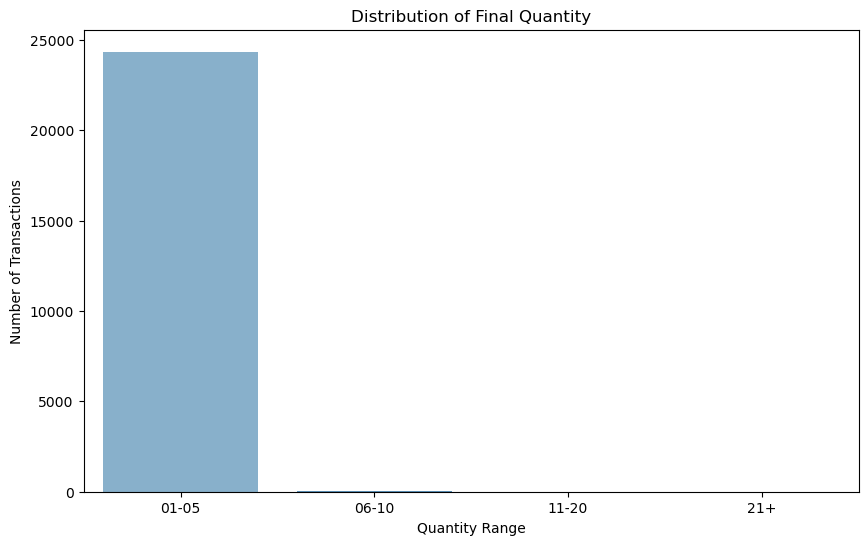

In [35]:
# Categorize the 'FINAL_QUANTITY' into specified ranges
bins = [0, 5, 10, 20, float('inf')]  # Define quantity ranges
labels = ['01-05', '06-10', '11-20', '21+']  # Corresponding labels for the ranges

Transactions['quantity_range'] = pd.cut(Transactions['FINAL_QUANTITY'], bins=bins, labels=labels, right=False)

# Group by 'quantity_range' and count the number of occurrences for each range
quantity_distribution = Transactions['quantity_range'].value_counts().reset_index()
quantity_distribution.columns = ['quantity_range', 'count']

print(quantity_distribution)

# Visualizing with Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='quantity_range', y='count', data=quantity_distribution, palette="Blues_d")

# Add title and labels
plt.title('Distribution of Final Quantity')
plt.xlabel('Quantity Range')
plt.ylabel('Number of Transactions')
plt.show()

  sale_range  count
0      01-25  24165
1      25-50    209
2      50-75     23
3       100+      7
4     75-100      4


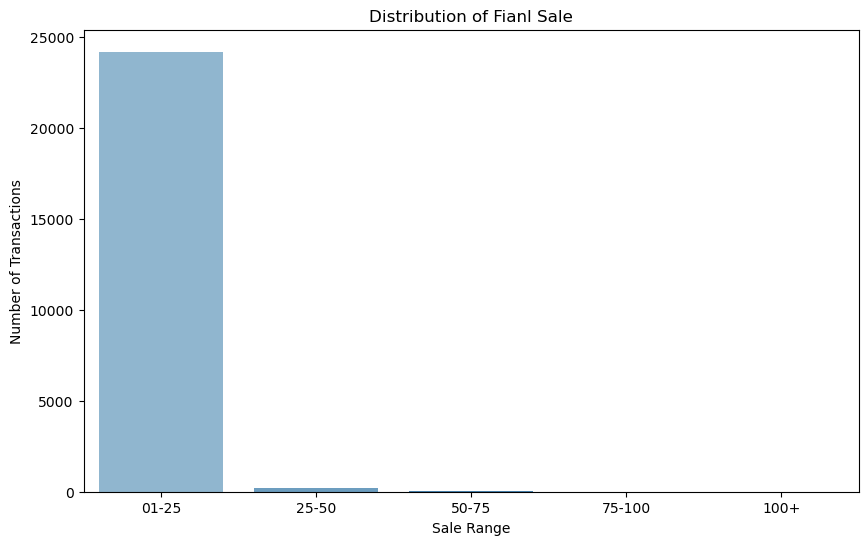

In [36]:
# Categorize the 'FINAL_SALE' into specified ranges
bins = [0, 25, 50, 75, 100, float('inf')]  # Define sale ranges
labels = ['01-25', '25-50', '50-75', '75-100', '100+']  # Corresponding labels for the ranges

# Creating a new column 'sale_range' based on the ranges
Transactions['sale_range'] = pd.cut(Transactions['FINAL_SALE'], bins=bins, labels=labels, right=False)

# Group by 'sale_range' and count the number of occurrences for each range
sale_distribution = Transactions['sale_range'].value_counts().reset_index()
sale_distribution.columns = ['sale_range', 'count']

print(sale_distribution)

# Visualizing with Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='sale_range', y='count', data=sale_distribution, palette="Blues_d")

# Add title and labels
plt.title('Distribution of Fianl Sale')
plt.xlabel('Sale Range')
plt.ylabel('Number of Transactions')
plt.show()

According to the charts above, there is a large number of transactions with quantities ranging from 1 to 5 and sales values between $ \text{\$} $1 and $ \text{\$} $25.

<a id="4"></a> 
### Products Table
1. Verify column types and filter out null `BARCODE`
2. Identify hierarchy of product categories
3. Drop duplicated rows

 [*Back to top*](#top)

In [37]:
# Display products table
Products

,CATEGORY_1,CATEGORY_2,CATEGORY_3,CATEGORY_4,MANUFACTURER,BRAND,BARCODE
0,Health & Wellness,Sexual Health,Conductivity Gels & Lotions,NaN,NaN,NaN,7.964944e+11
1,Snacks,Puffed Snacks,Cheese Curls & Puffs,NaN,NaN,NaN,2.327801e+10
2,Health & Wellness,Hair Care,Hair Care Accessories,NaN,PLACEHOLDER MANUFACTURER,ELECSOP,4.618178e+11
3,Health & Wellness,Oral Care,Toothpaste,NaN,COLGATE-PALMOLIVE,COLGATE,3.500047e+10
4,Health & Wellness,Medicines & Treatments,Essential Oils,NaN,MAPLE HOLISTICS AND HONEYDEW PRODUCTS INTERCHA...,MAPLE HOLISTICS,8.068109e+11
...,...,...,...,...,...,...,...
845547,Health & Wellness,Topical Muscle & Joint Relief Treatments,Braces & Wraps,NaN,NaN,NaN,7.223016e+11
845548,Snacks,Cookies,NaN,NaN,"TREEHOUSE FOODS, INC.",LOFTHOUSE,4.182082e+10
845549,Snacks,Candy,Confection Candy,NaN,HARIBO GMBH & CO KG,HARIBO,1.001672e+11
845550,Snacks,Nuts & Seeds,Hazelnuts,NaN,DOUBLE-COLA CO,JUMBO,7.539076e+10


In [38]:
Products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 845552 entries, 0 to 845551
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   CATEGORY_1    845441 non-null  object 
 1   CATEGORY_2    844128 non-null  object 
 2   CATEGORY_3    784986 non-null  object 
 3   CATEGORY_4    67459 non-null   object 
 4   MANUFACTURER  619078 non-null  object 
 5   BRAND         619080 non-null  object 
 6   BARCODE       841527 non-null  float64
dtypes: float64(1), object(6)
memory usage: 45.2+ MB


In [39]:
# Filter out null barcode
Products = Products[~Products['BARCODE'].isnull()]
Products.shape

(841527, 7)

In [40]:
# Identify hierarchy of product categories using groupby
Product_category = Products.groupby(['CATEGORY_1', 'CATEGORY_2', 'CATEGORY_3', 'CATEGORY_4'])['BARCODE'].count().reset_index(name='COUNT')

Product_category

,CATEGORY_1,CATEGORY_2,CATEGORY_3,CATEGORY_4,COUNT
0,Alcohol,Beer,Ale,Stout Ale,4
1,Alcohol,Beer,Lager,American Lager,114
2,Alcohol,Beer,Lager,Imported Lager,5
3,Alcohol,Wine,Red Wine,Cabernet Sauvignon,13
4,Alcohol,Wine,Red Wine,Malbec,2
...,...,...,...,...,...
121,Restaurant,Beverages,Soda,Diet Soda,29
122,Snacks,Puffed Snacks,Popcorn,Already Popped Popcorn,6956
123,Snacks,Puffed Snacks,Popcorn,Microwave Popcorn,2308
124,Snacks,Puffed Snacks,Popcorn,Popcorn Kernels & Popcorn Seasonings,712


In [41]:
# Drop duplicates
Products = Products.drop_duplicates()
Products.shape

(841369, 7)

In [42]:
# Check percentage of missing values 
missing_values_summary(Products)

,Column,Non-Null Count,% of Missing Values
0,CATEGORY_1,841258,0.013193
1,CATEGORY_2,840708,0.078562
2,CATEGORY_3,782655,6.978389
3,CATEGORY_4,67234,92.008976
4,MANUFACTURER,615152,26.886776
5,BRAND,615154,26.886538
6,BARCODE,841369,0.000000


In [43]:
num_barcode = Products['BARCODE'].nunique()
num_brand = Products['BRAND'].nunique()

print('Number of Distinct Barcode:', num_barcode)
print('Number of Distinct Brand:', num_brand)

Number of Distinct Barcode: 841342
Number of Distinct Brand: 8053


<a id="5"></a> 
## 2. Three Key Questions

<a id="6"></a> 
### 2.1 Explore the Data
Review the unstructured csv files and answer the following questions with code that supports your conclusions:  
**1. Are there any data quality issues present?**
  - **Data Accuracy**: For all three datasets, I ensured the data accurately reflects real-world values. For example, I removed unreasonable ages—such as users under 13 years old—to comply with Fetch's Terms of Service. Additionally, I verified the Fetch App release year to ensure that users registered their accounts after the release date.
  - **Data Completeness**: I checked column types and retained any non-numeric values if they were meaningful. However, I found a high percentage of missing values across the three tables. For example, 26.8% of brands are missing in the *Products* table, 3.7% of age are missing in the *User* table.
  - **Data Consistency**: I ensured data consistency within and across different datasets to support accurate analysis. For example, while reviewing the *Transactions* table, I identified an issue where the same receipt, purchase date, and barcode appeared in multiple rows but with different quantities and sales. To address this, I used aggregate functions to clean the data effectively.  

**2. Are there any fields that are challenging to understand?**
- **Category** in *Products* table: In the category column, I found that it's challenging to directly understand the hierarchy of each products, it have to use grouping function to see the subcategory of each product category. 
- **Barcode** column: Based on the ERM, it specifies that the barcode should be an integer data type, but I believe this is unreasonable because each barcode represents a unique key value for each product. Therefore, I kept the data type of the barcode as a string.
- *Transactions* Table: A significant issue in the *Transactions* table is the presence of multiple rows with the same `receipt_id`, `purchase_date`, `scan_date`, `user_id`, and `barcode`, even when `final_quantity` or `final_sale` is missing. I would like to determine whether this issue stems from a technical error or customer behavior. Additionally, it is important to identify solutions to prevent such problems in the future to ensure data analysis is conducted effectively and efficiently.

 [*Back to top*](#top)

<a id="7"></a> 
### 2.2 Provide SQL Queries
What are the top 5 brands by receipts scanned among users 21 and over?  
What are the top 5 brands by sales among users that have had their account for at least six months?  
Who are Fetch’s power users?  

 [*Back to top*](#top)

First, I performed an inner join between the _Products_ and _Transactions_ tables, finding that they matched with over 10,000 entries. However, when I inner joined with the _User_ table, I found only 130 rows. This indicates that **Fetch's users may have registered but never used the Fetch App (churned customers), or they might have scanned receipts while using guest mode**. This discrepancy is important to investigate, as it provides insight into the App's long-term customer engagement and lifetime value.

In [44]:
# Create an in-memory SQLite database
conn = sqlite3.connect(":memory:")

# Store DataFrames as SQL tables
User.to_sql("User", conn, index=False, if_exists="replace")
Transactions.to_sql("Transactions", conn, index=False, if_exists="replace")
Products.to_sql("Products", conn, index=False, if_exists="replace")

841369

In [45]:
# Run SQL query - Check for matching records between the Transactions and Products tables
query = '''
SELECT * 
FROM Transactions T INNER JOIN Products P using(barcode)

'''
transprod_result = pd.read_sql(query, conn)

# Display result
print(transprod_result.shape)
print(tabulate(transprod_result.head(10), headers="keys", tablefmt="psql"))

(12229, 16)
+----+--------------------------------------+---------------------+-------------+------------------------+--------------------------+-------------+------------------+--------------+------------------+--------------+-------------------+------------------------+-------------------------------------+-------------------------------+-----------------------------------+---------------+
|    | RECEIPT_ID                           | PURCHASE_DATE       | SCAN_DATE   | STORE_NAME             | USER_ID                  |     BARCODE |   FINAL_QUANTITY |   FINAL_SALE | quantity_range   | sale_range   | CATEGORY_1        | CATEGORY_2             | CATEGORY_3                          | CATEGORY_4                    | MANUFACTURER                      | BRAND         |
|----+--------------------------------------+---------------------+-------------+------------------------+--------------------------+-------------+------------------+--------------+------------------+--------------+-------

In [46]:
# Run SQL query - Check matching rows between transactions and user data

query_tuser = '''
SELECT * 
FROM Transactions T INNER JOIN User U on T.user_id = U.id
'''
transuser_result = pd.read_sql(query_tuser, conn)

# Display result
print(transuser_result.shape)
print(tabulate(transuser_result.head(10), headers="keys", tablefmt="psql"))

(130, 20)
+----+--------------------------------------+---------------------+-------------+---------------+--------------------------+-------------+------------------+--------------+------------------+--------------+--------------------------+----------------+--------------+---------+------------+----------+-------+------------------+-------------+------------------------+
|    | RECEIPT_ID                           | PURCHASE_DATE       | SCAN_DATE   | STORE_NAME    | USER_ID                  |     BARCODE |   FINAL_QUANTITY |   FINAL_SALE | quantity_range   | sale_range   | ID                       | CREATED_DATE   | BIRTH_DATE   | STATE   | LANGUAGE   | GENDER   |   AGE |   ACCOUNT_MONTHS | AGE_GROUP   | ACCOUNT_MONTHS_GROUP   |
|----+--------------------------------------+---------------------+-------------+---------------+--------------------------+-------------+------------------+--------------+------------------+--------------+--------------------------+----------------+--------

#### Question 1. What are the top 5 brands by receipts scanned among users 21 and over?

Using the main table, _Transactions_, I performed an left join with both the _User_ and _Products_ tables to count receipts by brand.

In [47]:
# Run SQL query - Top 5 brands by receipts scanned
query_1 = '''
SELECT BRAND, count(receipt_id) as COUNT
FROM Transactions T left join User U on U.id = T.user_id
LEFT JOIN Products P using(barcode)
WHERE age >= 21 and brand is not null
GROUP BY BRAND
ORDER BY COUNT desc
LIMIT 5
'''
q1_result = pd.read_sql(query_1, conn)

# Display result
print(q1_result)

             BRAND  COUNT
0      NERDS CANDY      3
1             DOVE      3
2          TRIDENT      2
3  SOUR PATCH KIDS      2
4           MEIJER      2


In [48]:
# Run SQL query - Details of products among the top 5 brand
query_1_detail = '''
SELECT RECEIPT_ID, FINAL_QUANTITY, FINAL_SALE, ID, AGE, ACCOUNT_MONTHS, CATEGORY_1, CATEGORY_2, CATEGORY_3, CATEGORY_4, MANUFACTURER, 
BRAND
FROM Transactions T JOIN User U on U.id = T.user_id
JOIN Products P using(barcode)
WHERE brand = 'DOVE' or brand = 'NERDS CANDY' or brand = 'SOUR PATCH KIDS' or brand = 'TRIDENT' or brand = 'COCA-COLA'
'''
q1_detail = pd.read_sql(query_1_detail, conn)

# Display result
print(tabulate(q1_detail.head(10), headers="keys", tablefmt="psql"))

+----+--------------------------------------+------------------+--------------+--------------------------+-------+------------------+-------------------+------------------------+------------------+--------------+------------------------+-----------------+
|    | RECEIPT_ID                           |   FINAL_QUANTITY |   FINAL_SALE | ID                       |   AGE |   ACCOUNT_MONTHS | CATEGORY_1        | CATEGORY_2             | CATEGORY_3       | CATEGORY_4   | MANUFACTURER           | BRAND           |
|----+--------------------------------------+------------------+--------------+--------------------------+-------+------------------+-------------------+------------------------+------------------+--------------+------------------------+-----------------|
|  0 | 04359032-f079-4fa3-b02d-0f97348b8f11 |                1 |         1.25 | 6528a0a388a3a884364d94dc |  36.6 |             15.8 | Snacks            | Candy                  | Confection Candy |              | FERRARA CANDY COMPA

Based on the table above, among the five brands, I believe SOUR PATCH KIDS and NERDS CANDY are the two main competitors in the confectionery candy market, while TRIDENT focuses on gum. Additionally, DOVE appears to be a popular choice for bar soap and body wash products.

#### Question 2.2 What are the top 5 brands by sales among users that have had their account for at least six months?  

Using the main table, _Transactions_, I performed an left join with both the _User_ and _Products_ tables can calculate total sales by brand.

In [49]:
# Run SQL query - Top 5 brands by sales
query_2 = '''
SELECT brand, round(sum(final_sale), 2) as TOTAL_SALE
FROM Transactions T LEFT JOIN User U on U.id = T.user_id
LEFT JOIN Products P using(barcode)
WHERE ACCOUNT_MONTHS >= 6 AND brand is not null
GROUP BY brand
ORDER BY TOTAL_SALE desc
LIMIT 5
'''
q2_result = pd.read_sql(query_2, conn)

# Display result
print(q2_result)

         BRAND  TOTAL_SALE
0          CVS       72.00
1         DOVE       30.91
2      TRIDENT       23.36
3  COORS LIGHT       17.48
4     TRESEMMÉ       14.58


In [50]:
# Run SQL query - Details of unit price by brand
query_2_detail = '''
SELECT brand, round(avg(final_sale), 2) as AVE_SALE, round(avg(final_quantity), 2) as AVG_QUANTITY
FROM Transactions T INNER JOIN User U on U.id = T.user_id
INNER JOIN Products P using(barcode)
WHERE brand is not null
GROUP BY brand
ORDER BY AVE_SALE desc, AVG_QUANTITY desc
LIMIT 10
'''
q2_detail = pd.read_sql(query_2_detail, conn)

# Display result
print(q2_detail)

                           BRAND  AVE_SALE  AVG_QUANTITY
0                            CVS     72.00           1.0
1                    COORS LIGHT     17.48           1.0
2                       TRESEMMÉ     14.58           2.0
3                PEPPERIDGE FARM     11.79           1.0
4                        TRIDENT     11.68           1.0
5                           DOVE     10.30           1.0
6                          CREST      8.97           1.0
7                         QUAKER      8.30           1.0
8                            AXE      7.99           1.0
9  ENTENMANN'S SWEET BAKED GOODS      6.29           1.0


Based on the results above, I can summarize that CVS, DOVE, and TRIDENT had the highest sales among users with transactions and accounts that have been active for at least six months. When examining the details of average sales and quantity by brand, I observed that these brands tend to sell products with a higher unit price compared to other brands, indicating that customers are spending more money on these items.

Therefore, I recommend that **Fetch explore potential partnerships with high-unit-price brands, as this could provide customers with more opportunities to earn rewards and, in turn, enhance app loyalty**. This strategy would not only boost customer engagement but also drive higher-value transactions, reinforcing brand partnerships and long-term customer retention.

#### Question 2.3 Who are Fetch’s power users?

Define Power Users:
- Power users are those with more than 2 receipts scanned in the past year and significant spending.

In [51]:
# Run SQL query - Fetch's power users
query_3 = '''
SELECT ID, count(receipt_id) as NUM_RECEIPTS, round(sum(final_sale), 2) as TOTAL_SALE
FROM Transactions T LEFT JOIN User U on U.id = T.user_id
WHERE ID is not null
GROUP BY ID
HAVING NUM_RECEIPTS > 1
ORDER BY TOTAL_SALE desc, NUM_RECEIPTS desc
LIMIT 5
'''
q3_result = pd.read_sql(query_3, conn)

# Display result
print(q3_result)

                         ID  NUM_RECEIPTS  TOTAL_SALE
0  643059f0838dd2651fb27f50             2       75.99
1  62ffec490d9dbaff18c0a999             3       26.14
2  61a58ac49c135b462ccddd1c             3       14.99
3  5fc12a8a16770448f92e56b8             2       14.67
4  632fc9dc0c625b72ae991f83             2       14.27


Based on the result, the top user scanned 2 receipts and spent $ \text{\$} $75.99, while others scanned 2-3 receipts and had total sales ranging from $ \text{\$} $14.27 to $ \text{\$} $26.14 .

<a id="8"></a>
### 2.3 Communicate with stakeholders

 [*Back to top*](#top)

**Subject: Data Quality Issues and Insights from Recent Investigation**

Hi stakeholders,  
I wanted to share a quick summary of my investigation and some key points on the data:

**Data Quality Issues:**
- Missing Data: I've found that 26.8% of brands in the Products table and 3.7% of ages in the User table are missing.
- Inconsistencies: In the Transactions table, some receipts are duplicated with different quantities and sales. I’ve cleaned this up but would like to understand whether this is a technical issue or user behavior.  

**Insights:**
- User Engagement: There’s a large mismatch between users and transactions—only 130 users matched when joining with the User table, suggesting that many users may have churned or scanned receipts in guest mode.
- Top Brands: CVS, DOVE, and TRIDENT have the highest sales among users active for at least six months. These brands have higher unit prices, which could be a great opportunity for partnership to boost customer loyalty.
- Power Users: I’ve identified top users who scan receipts and spend significantly. Targeting these users with rewards could increase engagement.  

**Actions Request:**
Can you help explore solutions for the missing data and assist with understanding the user-transaction mismatch to improve customer engagement insights?

Let me know if you’d like to discuss further.

Warm regards,  
Allison Liu